<a href="https://colab.research.google.com/github/caalinlu/PyTorch/blob/master/PyTorch%E5%AE%9E%E7%8E%B0L1%EF%BC%8CL2%E6%AD%A3%E5%88%99%E5%8C%96%E4%BB%A5%E5%8F%8ADropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 什么是dropout（随机激活）？

1.   dropout是一种Regularization的方法，与L1、L2正则化和最大范式约束等方法互为补充。在训练的时候，dropout的实现方法是让神经元以超参数p的概率被激活或者设置为0
2.  在训练过程中，随机失活可以被认为是对完整的神经网络抽样出一些子集，每次基于输入数据只更新子网络的参数（然而，数量巨大的子网络们并不是互相独立的，因为它们都共享参数）
3.   在测试过程中不是用随机失活，所有的神经元都激活，但是对于隐层的输出都要乘以概率p。可以理解为是对数量巨大的子网络们做了模型集成（model ensemble），以此来计算出一个平均的预测。
4.   一般在全连接层神经元置为0，在卷积层中可能把某个通道置为0。



In [1]:
from __future__ import print_function
import torch as t
t.__version__

'1.1.0'

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import matplotlib.pyplot as plt

In [0]:
class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(Net, self).__init__()
        
        # 卷积层‘1’表示输入图片为单通道，‘6’表示输出通道数，‘5’表示卷积核为5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 卷积层
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 仿射层/全连接层，y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # 卷积 -> 激活 -> 池化
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # reshape, '-1'表示自适应
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [4]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## L1正则化
对于每一个w我们都向目标函数增加一个λ|w|。
L1正则化有一个有趣的性质，它会让权重向量在最优化的过程中变得稀疏（即非常接近0）。
也就是说，使用L1正则化的神经元最后使用的使他们最重要的输入数据的稀疏子集，同时对噪音输入则几乎是不变的了。
相较L1正则化，L2正则化中的权重向量大多是分散的小数字。在实践中，如果不是特别管制某些明确的特征选择，一般来说L2正则化都会比L1正则化效果好。
PyTorch里的optimizer只能实现L2正则化，L1正则化只能手动实现。

In [0]:
# 定义输入和目标
input = t.randn(1, 1, 32, 32)
target = t.arange(0, 10).view(1, 10)
target = target.float()

# 定义损失
criterion = nn.MSELoss()
op = optim.SGD(net.parameters(), lr = 0.1)
regularization_loss = 0
lamda = 0.4

# 前向传播
output = net(input)

# 得到参数正则化损失表达式
for para in net.parameters():
  regularization_loss += t.sum(abs(para))

#    损失函数计算
classify_loss = criterion(output, target)

# 目标函数（正则化项 + 损失函数）计算
loss = regularization_loss + classify_loss

# 反向传播
loss.backward()

# 优化器优化（梯度下降）
op.step()


## L2正则化
对于网络中的每个权重w，向目标函数中增加一个$\frac{1}{2} \lambda \omega^{2}$，其中$\lambda$是正则化强度。这样改式子关于梯度就是$\lambda \omega$了。
L2正则化可以直观理解为它对大数值的权重进行严厉惩罚，倾向于更加分散的权重向量。
最后需要注意在梯度下降和参数更新的时候，使用L2正则化一维这所有的权重都以$\omega$ +=  -$\lambda $ * $\omega$向着0线性下降。
选择一个合适的权重衰减系数$\lambda$非常重要，这个需要根据具体情况去尝试，初步尝试可以使用1e-4或者1e-3。
在PyTorch中某些optimizer优化器的参数weight_dacay(float, optional)就是L2正则项，它的默认值为0


```
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0.001)
```



## PyTorch1.0实现dropout
数据少，才能凸显过拟合问题，所以我们就做10个数据点。

torch.Size([20, 1])


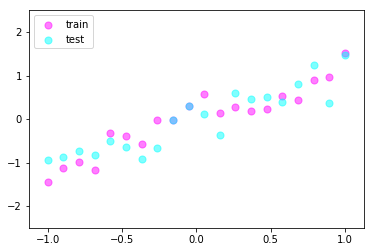

In [15]:
t.manual_seed(1) 

N_SAMPLES = 20
N_HIDDEN = 300

# training data
x = t.unsqueeze(t.linspace(-1, 1, N_SAMPLES), 1)
print(x.size())

#  torch.normal(mean, std, out=None) → Tensor
y = x + 0.3 * t.normal(t.zeros(N_SAMPLES, 1) , t.ones(N_SAMPLES, 1))

# test data
test_x = t.unsqueeze(t.linspace(-1, 1, N_SAMPLES), 1)
test_y = test_x + 0.3 * t.normal(t.zeros(N_SAMPLES, 1), t.ones(N_SAMPLES,1))

# show data
plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.5, label='train')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

## nn.Sequential
nn.Sequential是一个有序的容器，神经网络模块将按照传入构造器的顺序依次被添加到计算图中执行，同时以神经网络模块为元素的有序字典也可以作为传入参数。


看一下例子：

In [0]:
# Example of using Sequetial
model = nn.Sequential(
        nn.Conv2d(1, 20, 5),
        nn.ReLU(),
        nn.Conv2d(20, 64, 5),
        nn.ReLU()
        )

# Example of using Sequetial
model = nn.Sequetial(OrderedDict([
        ('Con2d', nn.Conv2d(1, 20, 5)),
        ('ReLu', nn.ReLU()),
        ('Con2d', nn.Conv2d(20, 64, 5)),
        ('ReLU', nn.ReLU())]))

在介绍了nn.Sequential()之后，我们现在搭建两个神经网络，一个没有dropout,一个有dropout。

可以看但到没有dropout的容易出现过拟合，那我们就命名为net_overfitting,另一个就是 net_dropped。

In [0]:
net_overfitting = nn.Sequential(
                  nn.Linear(1, N_HIDDEN),
                  nn.ReLU(),
                  nn.Linear(N_HIDDEN, N_HIDDEN),
                  nn.ReLU(),
                  nn.Linear(N_HIDDEN, 1),
                  )

net_dropout = nn.Sequential(
              nn.Linear(1, N_HIDDEN),
              nn.Dropout(0.5),
              nn.ReLU(),
              nn.Linear(N_HIDDEN, N_HIDDEN),
              nn.Dropout(0.5),
              nn.ReLU(),
              nn.Linear(N_HIDDEN, 1),)


注意：PyTorch的训练模式和测试模式切换


由于训练的时候Dropout和BN层起作用，每个bacth BN层的参数不一样，dropout在训练时随机失效点具有随机性，所以训练和测试要区分开来。
使用是切记要根据实际切换：
model.train()
model.eval()

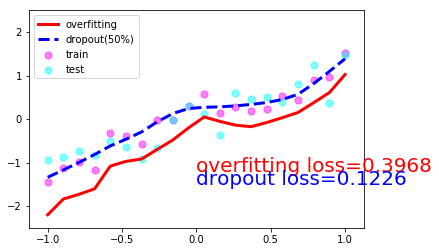

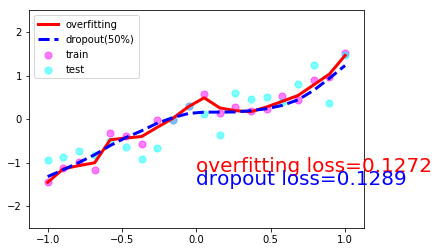

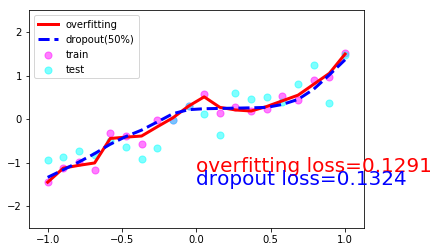

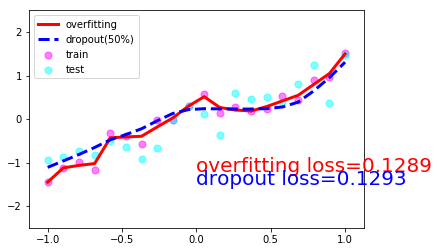

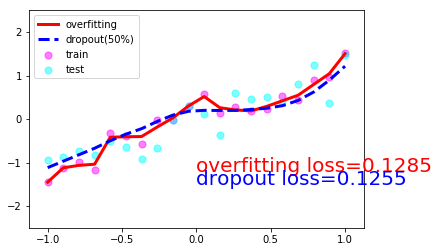

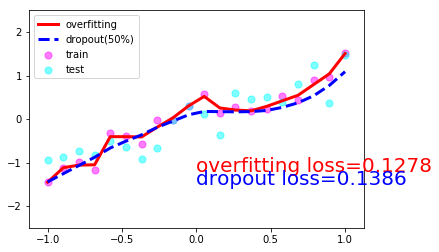

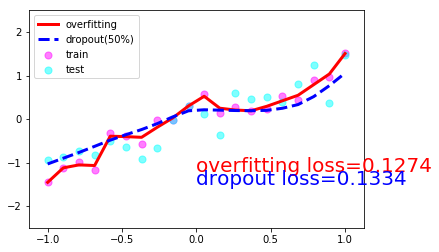

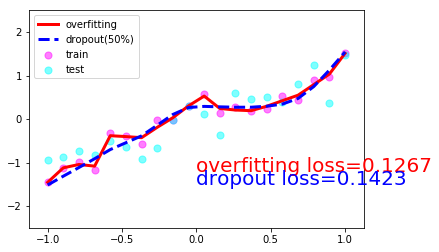

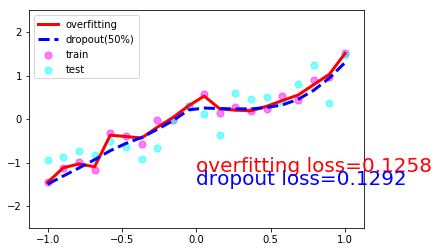

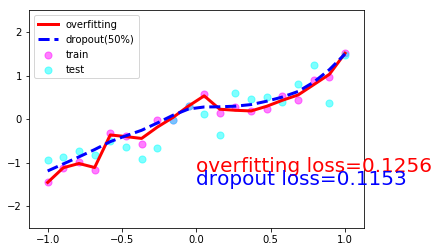

In [28]:
optimizer_ofit = optim.Adam(net_overfitting.parameters(), lr=0.001)
optimizer_drop = optim.Adam(net_dropout.parameters(), lr= 0.01)
loss = t.nn.MSELoss()

for epoch in range(500):

  
  # 前向传播
  pred_ofit = net_overfitting(x)
  pred_drop = net_dropout(x)
  
  # 损失函数计算
  loss_ofit = loss(pred_ofit, y)
  loss_drop = loss(pred_drop, y)
  
      
  # 梯度清零(注意梯度清零是在优化器中)
  optimizer_ofit.zero_grad()
  optimizer_drop.zero_grad()

  
  # 反向传播
  loss_ofit.backward()
  loss_drop.backward()
  
  # 梯度下降
  optimizer_ofit.step()
  optimizer_drop.step()
  
  if epoch % 50 == 0:
    
    # 将神经网络转换成测试形式，此时不会对神经网络dropout   
    net_overfitting.eval()
    net_dropout.eval()
    
    test_pred_ofit = net_overfitting(test_x)
    test_pred_drop = net_dropout(test_x)
    
    # show data
    plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.5, label='train')
    plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.5, label='test')
    plt.plot(test_x.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
    plt.plot(test_x.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
    plt.text(0, -1.2, 'overfitting loss=%.4f' % loss(test_pred_ofit, test_y).data.numpy(), fontdict={'size': 20, 'color':  'red'})
    plt.text(0, -1.5, 'dropout loss=%.4f' % loss(test_pred_drop, test_y).data.numpy(), fontdict={'size': 20, 'color': 'blue'})
    plt.legend(loc='upper left')
    plt.ylim((-2.5, 2.5))
    plt.pause(0.1)
    
    
    net_overfitting.train()
    net_dropout.train()
    
plt.ioff()
plt.show()

  